In [82]:
from spacy.en import English
import codecs
import re
import os
import unidecode

In [2]:
parser = English()

# Getting tweets from elasticsearch

In [3]:
tweets = []
from elasticsearch import Elasticsearch
es = Elasticsearch()
res = es.search(index="twitter", doc_type="statuses", size=10000, body={"query": {
        "match_all": {}
    }})
for doc in res['hits']['hits']:
    tweets.append(doc['_source']['text'])

In [4]:
len(tweets)

8305

# Trying out word similarity

In [24]:
from numpy import dot
from numpy.linalg import norm

# you can access known words from the parser's vocabulary
nasa = parser.vocab[u"computer"]

In [25]:
cosine = lambda v1, v2: dot(v1, v2) / (norm(v1) * norm(v2))

In [26]:
allWords = list({w for w in parser.vocab if w.has_vector and w.orth_.islower() and w.lower_ != "nasa"})

In [27]:
# sort by similarity to NASA
allWords.sort(key=lambda w: cosine(w.vector, nasa.vector))
allWords.reverse()
print("Top 10 most similar words to NASA:")
for word in allWords[:10]:   
    print(word.orth_)

Top 10 most similar words to NASA:
computer
computers
workstation
mainframe
laptop
microcomputer
pc
microprocessor
microcontroller
pda


# Creating the tweets file

In [5]:
tweets_filepath = os.path.join('tweets_all.txt')

# Saving all the tweets in file

In [367]:
%%time
with codecs.open(tweets_filepath, 'w', encoding='utf_8') as f:
        for tweet in tweets:
                #print "Orig: "+tweet
                #print 'Orig New '+unidecode.unidecode(tweet)
                tweet = unidecode.unidecode(tweet)
                #removing out the Retweet word, @abc, url and hash from hashtag
                tweet = re.sub(r"http\S+", " ", tweet,flags=re.IGNORECASE)
                tweet = re.sub(r"#", " ", tweet,flags=re.IGNORECASE)#|RT|@\S+|-|'|%|\'|\(|\)|;|:|&nbsp;|'s|’|\"|&amp|’s|\U000\S+
                tweet = re.sub(r"RT", " ", tweet,flags=re.IGNORECASE)
                tweet = re.sub(r"@\S+", " ", tweet,flags=re.IGNORECASE)
                #for removing the &gt;
                tweet = re.sub(r"&\S+", " ", tweet,flags=re.IGNORECASE)
                tweet = re.sub(r"-", "",tweet)
                tweet = re.sub(r"&nbsp;", " ", tweet,flags=re.IGNORECASE)
                tweet = re.sub(r"%", " ",tweet)
                tweet = re.sub(r"'s", " ", tweet,flags=re.IGNORECASE)
                tweet = re.sub(r"\'", "",tweet)
                tweet = re.sub(r"\\", "",tweet)
                tweet = re.sub(r"/", "",tweet)
                tweet = re.sub(r"\(", " ",tweet)
                tweet = re.sub(r"\)", " ",tweet)
                tweet = re.sub(r";", " ",tweet)
                tweet = re.sub(r":", " ",tweet)
                tweet = re.sub(r"[.]{2,}"," ", tweet)
                tweet = re.sub(r"\"", " ",tweet)
                tweet = re.sub(r"<", " ",tweet)
                tweet = re.sub(r">", " ",tweet)
                tweet = re.sub(r"\[", " ",tweet)
                tweet = re.sub(r"\]", " ",tweet)
                tweet = re.sub(r"\{", " ",tweet)
                tweet = re.sub(r"\}", " ",tweet)
                tweet = re.sub(r"\|", " ",tweet)
                tweet = re.sub(r"=", " ",tweet)
                tweet = re.sub(r"~", " ",tweet)
                tweet = re.sub(r"\`", " ",tweet)
                tweet = re.sub(r"\^", " ",tweet)
                tweet = re.sub(r"\+", " ",tweet)
                tweet = re.sub(r"!", " ",tweet)
                tweet = re.sub(r"\*", " ",tweet)
                
                tweet = re.sub(r" [a-z0-9] ", " ",tweet)
               # tweet = re.sub(r"^[a-z0-9] ", " ",tweet)
               # tweet = re.sub(r" [a-z0-9]$", " ",tweet)
                #tweet = re.sub(r"[a-z]", "",tweet)
                tweet = re.sub(r"&amp", " ", tweet,flags=re.IGNORECASE)
                tweet = re.sub(r"\\U\S+", " ", tweet,flags=re.IGNORECASE)
                tweet = " ".join(tweet.split())
                #print "Axed: "+tweet
                f.write(tweet+'\n')

CPU times: user 873 ms, sys: 33.4 ms, total: 906 ms
Wall time: 916 ms


# Applying the tokenization & stemming ad again saving in some file

In [368]:
def punct_space_stopword(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space or token.is_stop

def line_tweet(filename):
    """
    generator function to read in tweets from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for tweet in f:
            yield tweet.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse tweet,
    lemmatize the text, and yield sentences
    """
    
    for parsed_tweet in parser.pipe(line_tweet(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_tweet.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space_stopword(token)])

In [369]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import pandas as pd
import itertools as it

In [370]:
unigram_sentences_filepath = os.path.join('unigram_sentences_all.txt')

In [371]:
%%time
with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(tweets_filepath):
            f.write(sentence + '\n')

CPU times: user 11.1 s, sys: 174 ms, total: 11.3 s
Wall time: 12.5 s


In [372]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [373]:
for unigram_sentence in it.islice(unigram_sentences, 200, 210):
    print u' '.join(unigram_sentence)
    print u''

session

soros pledge 10m fight hate crime trump win funny thing fund riot

happy trump admin

pelosi use gov contract help real estate hillary

month admin

everyday wake russian tie

compromise

trump sessions russia

wise word trump jointaddress jointsession

break dhs insider cia mossad dc pedo ring pedogate pizzagate maga trump mondaymotivation



In [374]:
sntnc = LineSentence(tweets_filepath)

for unigram_sentence in it.islice(sntnc, 200, 210):
    print u' '.join(unigram_sentence)
    print u''

Obama ratings on first address to Congress topped Trump

TRUMP DAILY The House probe into Trump and Russia is already splintering Trump

Pelosi says Sessions lied under oath and must resign now . Hmmm what about Hillary? Trump News CNN

Research suggests the waste products produced by these bacteria when they tuck into the delicious sweat Trump emits may

Liberals have fantasy of an all brown and transgender world. Clinically insane people. The AltRight and Trump will put stop to this.

EXC Trump exec order delayed because he is considering more countries for the travel ban, Iraqi official says.

Patrick Leahy is wrong. Session should NOT recuse himself,and it is not required. Integrity is NOT the highlight of BHOs hadow on Trump

Shuck Schumer Calls for Attorney General Sessions to Resign Over Bogus Russian Conspiracy

Obama focused on addressing Gerrymandering votersuppression, 2018 midterms. trump admin imploding in its own.

Why isnt Trump on Twitter yet? Oh JeffSessions Russia per

# Creating Bigram Model 

In [375]:
bigram_model_filepath = os.path.join('bigram_model_all')

In [376]:
bigram_model = Phrases(unigram_sentences)
bigram_model.save(bigram_model_filepath)

#loading the model
bigram_model = Phrases.load(bigram_model_filepath)

In [377]:
bigram_sentences_filepath = os.path.join('bigram_sentences_all.txt')

In [378]:
%%time
with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for unigram_sentence in unigram_sentences:    
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
        f.write(bigram_sentence + '\n')

CPU times: user 575 ms, sys: 46.5 ms, total: 621 ms
Wall time: 635 ms


In [379]:
bigram_sentences = LineSentence(bigram_sentences_filepath)
for bigram_sentence in it.islice(bigram_sentences, 2020, 2150):
    print u' '.join(bigram_sentence)
    print u''

ugly irony democrats russia witchhunt trump

basically put hope theresamay govt safely brexit like believe trump

resist trump have_tell past_resistance movement_candycoated garbage

indivisibleteam carlinkim beauwillimon need

resist trump

need trump putin butt buddy

way world trump pence know_far line arrest new election call

feel ur listen americans betrayer mccain graham unseat luv newt trump

alinsky democrats medium work switch narrative successful trump speech manufactured scandal

session

win president_donald trump announce twitter saturday attend year white_house corre

want russians trump hillary sell uranium russians obama catch ope

not intend tweet long

trump donaldtrump_thursdaymotivation

ap cast trump inclusion carryn owen term exploitation

long vid russian mention putin think trump store

justice ministry refuse demolish house abu khdeir murderer news_politics clinton trump follow

nasa defiantly communicate climatechange science despite trump doubt

think kid st

# Creating Trigram Model

In [550]:
trigram_model_filepath = os.path.join('trigram_model_all')

In [551]:
trigram_model = Phrases(bigram_sentences)
trigram_model.save(trigram_model_filepath)

In [552]:
trigram_model = Phrases.load(trigram_model_filepath)

In [553]:
trigram_sentence_filepath = os.path.join('trigram_sentences.txt')

In [554]:
%%time
with codecs.open(trigram_sentence_filepath, 'w', encoding='utf-8') as f:
    for sentence in bigram_sentences:
        trigram_sentence = u' '.join(trigram_model[sentence])
        f.write(trigram_sentence+'\n')

CPU times: user 508 ms, sys: 37 ms, total: 545 ms
Wall time: 548 ms


In [555]:
trigram_sentences = LineSentence(trigram_sentence_filepath)

In [556]:
for unigram_sentence in it.islice(unigram_sentences, 220, 250):
    print u' '.join(unigram_sentence)
    print u''

danrather say trump russia scandal explode like bomb cbsnews trumpadministration

trump organisation vast able separate politics business

apparently can not racist white people thisiswhyweneedtrump trump racisttowardswhitepeople

breaking trump android device believed source recent white house leaks seatt

lindsey graham try cock block trump loser

send trump scotland piss away indyref2 buy airbeds people

trump know know

trumpgate ethicsmatter intelligencematters threattodemocracy

trump dossier fake

reason trump altleft

surreal watch try normalize light trump attorney general perjure fro

pussy grab politics society trump meme funny pussy

maga trump fox news poll 59 independent confidence presidency republicans 93

operation trump ordinary spying op connection putin limit fsu channel bc agent not rentacops

20 year applaud trump political rise fall docudrama series receive yuge award russiagate

puta pelosi proud dignity show trump address

political karma

go come

trump team d

In [416]:
%%time
for parsed_tweet in parser.pipe(line_tweet(bigram_sentences_filepath),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_tweet.sents:
            noun_word =  [token.lemma_ for token in sent
                             if token.pos_ == "NOUN"]
            if len(noun_word) > 0:
                print noun_word

[u'russia', u'tie', u'jeff_session']
[u'minion', u'socalledpresident', u'trump', u'care']
[u'face']
[u'suppo', u'session', u'trump', u'maga']
[u'obamacare', u'today']
[u'healthcarereform', u'trump', u'aca_obamacare']
[u'tape', u'scrotus', u'search', u'box', u'trump', u'call', u'ruler', u'united_state']
[u'anybody', u'trump', u'administration', u'doll']
[u'ohhh', u'trump', u'metaphor', u'wotus']
[u'investor', u'trump', u'brexit', u'mind', u'superreturn', u'eurogrowth']
[u'privacy', u'concern', u'trump', u'reform', u'security', u'nation']
[u'trump', u'usa', u'newtrump']
[u'muslimban']
[u'example', u'child', u'refugee']
[u'trump', u'session']
[u'hope', u'woman', u'trump']
[u'corporation', u'tax', u'break', u'cap', u'trump']
[u'book', u'address', u'concern', u'harry', u'nelson', u'news', u'aca_obamacare', u'trump']
[u'depa_ment', u'smoke', u'notion']
[u'trump', u'russia']
[u'vet', u'pension', u'housing', u'trump', u'djt', u'potus', u'congre']
[u'trump', u'meps', u'citizen', u'eu', u'citize

In [380]:
%%time
for parsed_tweet in parser.pipe(line_tweet(bigram_sentences_filepath),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_tweet.sents:
            proper_noun_word = [token.lemma_ for token in sent
                                if token.pos_ == "PROPN"]
            if len(proper_noun_word) > 0:
                print proper_noun_word

[u'ag']
[u'conan_obrien', u'empathetic_trip']
[u'boris']
[u'abraham']
[u'fbi']
[u'huffington']
[u'israel']
[u'el', u'gop']
[u'gabriel']
[u'al']
[u'epa']
[u'suppo', u'nato']
[u'horse']
[u'cia']
[u'valerie_jarrett']
[u'russia_probe']
[u'uss_gerald']
[u'gop']
[u'july']
[u'zeke']
[u'sweden']
[u'dr']
[u'wo_not', u'stockholm']
[u'tht']
[u'fn', u'ukip']
[u'kellyanne_conway']
[u'fbi']
[u'hillary_clinton']
[u'senate']
[u'chris', u'steele']
[u'kim']
[u'kim']
[u'cnbc']
[u'pa']
[u'tax_return']
[u'wilbur']
[u'va']
[u'democrat']
[u'mnuchin', u'devos', u'ross']
[u'jr']
[u'jfk']
[u'david']
[u'rochester', u'ny']
[u'special_day']
[u'flynn']
[u'president', u'virginia']
[u'vault7']
[u'jared_kushner', u'u.s']
[u'yemen_raid']
[u'cia']
[u'wellington']
[u'wilbur']
[u'r']
[u'fbi']
[u'3m']
[u'gorka']
[u'epa']
[u'dr']
[u'jr']
[u'al']
[u'gina', u'haspel']
[u'sergey_kislyak']
[u'johnny', u'manziel']
[u'scott']
[u'epa']
[u'democrat_pa']
[u'epa']
[u'democrats', u'russians']
[u'israel']
[u'cu']
[u'cia']
[u'amitai']
[

In [557]:
for parsed_tweet in parser.pipe(line_tweet(bigram_sentences_filepath),
                                  batch_size=10000, n_threads=4):
        
        for num, entity in enumerate(parsed_tweet.ents):
            print 'Entity {}:'.format(num + 1), entity, '-', entity.label_
            print ''

Entity 1: 246 - CARDINAL

Entity 1: 51 - CARDINAL

Entity 2: 61 minute - TIME

Entity 1: 2020 - DATE

Entity 1: 88 percent - PERCENT

Entity 1: indian - NORP

Entity 1: 88 percent - PERCENT

Entity 1: 2all - CARDINAL

Entity 1: 4th - ORDINAL

Entity 1: republican - NORP

Entity 1: conan_obrien empathetic_trip - ORG

Entity 1: democrats - NORP

Entity 1: 19 - CARDINAL

Entity 1: 140 - CARDINAL

Entity 1: 11am3pm cst - MONEY

Entity 1: 78 - CARDINAL

Entity 1: 2008 - DATE

Entity 1: 25 year ago - DATE

Entity 2: 25 year ago - DATE

Entity 1: 13 - CARDINAL

Entity 1: 17 - CARDINAL

Entity 1: russia - GPE

Entity 1: democrats - NORP

Entity 1: 10m - CARDINAL

Entity 1: 59 - CARDINAL

Entity 2: 93 - CARDINAL

Entity 1: 20 year - DATE

Entity 1: democrats - NORP

Entity 1: 44 year - DATE

Entity 1: 21,000 - CARDINAL

Entity 1: 3 - CARDINAL

Entity 1: 1 - CARDINAL

Entity 1: 2a_law - CARDINAL

Entity 1: 7 million - CARDINAL

Entity 2: 400 - CARDINAL

Entity 1: 2011 - DATE

Entity 1: 2018 - DA

# Trying to find out similar words 

In [558]:
from gensim.models import Word2Vec

trigram_sentences = LineSentence(trigram_sentence_filepath)
word2vec_filepath = os.path.join('word2vec_model_all')

# Training the word2vec model

In [559]:
%%time
word2vec = Word2Vec(trigram_sentences, size=200, window=5, min_count=25, sg=1, workers=4)

CPU times: user 801 ms, sys: 57.6 ms, total: 858 ms
Wall time: 638 ms


In [560]:
word2vec.save(word2vec_filepath)

In [561]:
%%time
for i in range(1,12):
    word2vec.train(trigram_sentences)
    word2vec.save(word2vec_filepath)

CPU times: user 8.07 s, sys: 636 ms, total: 8.7 s
Wall time: 6.15 s


In [562]:
word2vec = Word2Vec.load(word2vec_filepath)
word2vec.init_sims()

In [563]:
print u'{:,} terms in the word2vec vocabulary.'.format(word2vec.corpus_count)

12,708 terms in the word2vec vocabulary.


In [564]:
word2vec.build_vocab

<bound method Word2Vec.build_vocab of <gensim.models.word2vec.Word2Vec object at 0x1171ae0d0>>

In [565]:
def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """

    for word, similarity in word2vec.most_similar(positive=[token], topn=topn):

        print u'{:20} {}'.format(word, round(similarity, 3))

In [592]:
get_related_terms(u'hillary')#action#immigrant#syria#refugee#hillary#donaldtrump

email                0.375
have                 0.349
hack                 0.338
hate                 0.333
fail                 0.308
remember             0.3
intelligence         0.294
r                    0.293
cause                0.293
tie_russia           0.292


In [569]:
word2vec.similar_by_word('donaldtrump')

[(u'president_donald', 0.35490429401397705),
 (u'presidenttrump', 0.3417971134185791),
 (u'video', 0.3296266198158264),
 (u'impeachtrump', 0.3273525834083557),
 (u'late', 0.3216756582260132),
 (u'trumpaddress', 0.32147419452667236),
 (u'theresistance', 0.32055485248565674),
 (u'russian_ambassador', 0.31956514716148376),
 (u'usa', 0.31131142377853394),
 (u'lie_oath', 0.29729583859443665)]

In [571]:
word2vec.corpus_count

12708

In [572]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in word2vec.wv.vocab.iteritems()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda (term, index, count): -count)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the word2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(word2vec.wv.syn0norm[term_indices, :],
                            index=ordered_terms)

word_vectors

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
trump,-0.017223,0.071908,-0.077789,-0.056885,0.051178,0.098327,-0.144239,-0.004144,0.017141,-0.000399,...,-0.063024,0.041343,0.041383,-0.119021,-0.074768,0.087203,-0.003995,-0.102423,-0.134411,-0.102233
russia,-0.054689,0.045070,-0.065463,-0.104645,-0.097741,0.101591,-0.027063,-0.073742,-0.122340,-0.116025,...,-0.026227,0.032338,-0.009883,-0.006092,0.012506,0.140007,0.043774,0.118103,0.079075,-0.103846
sessions,-0.115443,0.047539,0.027249,-0.085579,0.107379,0.173663,-0.077825,-0.124589,-0.067789,-0.045500,...,-0.121008,0.033255,-0.015846,-0.019923,-0.097672,0.003865,0.006064,-0.063687,-0.127874,-0.050076
maga,-0.007217,-0.023693,-0.052233,-0.017926,0.020560,-0.031847,-0.037754,-0.085246,0.089193,-0.111129,...,-0.111938,0.068521,-0.070830,-0.027714,-0.109430,0.019496,-0.001535,0.057220,-0.055892,-0.014287
not,-0.002791,0.007691,-0.028200,-0.052485,-0.034446,-0.107573,-0.106738,-0.018050,-0.078187,-0.100850,...,0.059419,0.021799,0.066437,0.054929,-0.187070,0.126707,-0.081616,-0.021683,-0.003837,-0.047599
obama,-0.130368,0.060293,0.129076,-0.039994,0.096532,-0.032846,-0.035227,0.035600,-0.027772,-0.027733,...,-0.122381,0.076896,0.014364,-0.061830,0.006117,-0.018921,-0.053412,-0.023296,0.037195,-0.125760
president,0.026924,-0.015260,-0.039031,-0.088125,0.029356,-0.061419,-0.049509,-0.002210,0.119462,0.043347,...,-0.077018,0.064490,-0.038943,-0.035113,-0.190160,0.057120,-0.003684,-0.016588,0.019893,0.038125
usa,0.010868,0.068854,0.034971,-0.096350,0.071989,-0.058987,-0.025935,-0.043261,0.056372,-0.029928,...,-0.023149,-0.070586,-0.063112,0.005295,-0.074072,-0.017642,-0.047773,0.049145,0.030218,-0.058827
lie,0.049458,-0.038943,-0.069227,-0.021138,0.023186,-0.032123,0.006954,0.080011,0.051264,0.044711,...,0.017622,0.054151,0.075116,-0.070413,0.001509,0.088746,0.004759,-0.018858,-0.210736,-0.173546
session,-0.023173,0.082776,0.118348,-0.019735,-0.060699,-0.036488,-0.125048,-0.091810,-0.074556,0.000787,...,-0.142980,0.028314,0.020758,-0.049394,-0.024675,0.038498,0.050214,-0.010271,-0.145495,-0.076327


# Creating the visualization

In [573]:
from sklearn.manifold import TSNE
import spacy

In [574]:
op = list(ordered_terms)

In [575]:
from collections import Counter
word_freq = Counter(word2vec.wv.vocab)
word_freq.most_common(10)

[(u'trump', <gensim.models.keyedvectors.Vocab at 0x11a7b3b10>),
 (u'russia', <gensim.models.keyedvectors.Vocab at 0x115355490>),
 (u'sessions', <gensim.models.keyedvectors.Vocab at 0x11a7b31d0>),
 (u'maga', <gensim.models.keyedvectors.Vocab at 0x10dca7250>),
 (u'not', <gensim.models.keyedvectors.Vocab at 0x10dca7fd0>),
 (u'obama', <gensim.models.keyedvectors.Vocab at 0x114d989d0>),
 (u'president', <gensim.models.keyedvectors.Vocab at 0x11a7b3b50>),
 (u'usa', <gensim.models.keyedvectors.Vocab at 0x11683fd50>),
 (u'lie', <gensim.models.keyedvectors.Vocab at 0x115355690>),
 (u'session', <gensim.models.keyedvectors.Vocab at 0x114d98290>)]

In [576]:
tsne_input = word_vectors.drop(spacy.en.STOPWORDS, errors=u'ignore')
tsne_input = tsne_input.head(50)

In [577]:
tsne_input.head(10)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
trump,-0.017223,0.071908,-0.077789,-0.056885,0.051178,0.098327,-0.144239,-0.004144,0.017141,-0.000399,...,-0.063024,0.041343,0.041383,-0.119021,-0.074768,0.087203,-0.003995,-0.102423,-0.134411,-0.102233
russia,-0.054689,0.045070,-0.065463,-0.104645,-0.097741,0.101591,-0.027063,-0.073742,-0.122340,-0.116025,...,-0.026227,0.032338,-0.009883,-0.006092,0.012506,0.140007,0.043774,0.118103,0.079075,-0.103846
sessions,-0.115443,0.047539,0.027249,-0.085579,0.107379,0.173663,-0.077825,-0.124589,-0.067789,-0.045500,...,-0.121008,0.033255,-0.015846,-0.019923,-0.097672,0.003865,0.006064,-0.063687,-0.127874,-0.050076
maga,-0.007217,-0.023693,-0.052233,-0.017926,0.020560,-0.031847,-0.037754,-0.085246,0.089193,-0.111129,...,-0.111938,0.068521,-0.070830,-0.027714,-0.109430,0.019496,-0.001535,0.057220,-0.055892,-0.014287
obama,-0.130368,0.060293,0.129076,-0.039994,0.096532,-0.032846,-0.035227,0.035600,-0.027772,-0.027733,...,-0.122381,0.076896,0.014364,-0.061830,0.006117,-0.018921,-0.053412,-0.023296,0.037195,-0.125760
president,0.026924,-0.015260,-0.039031,-0.088125,0.029356,-0.061419,-0.049509,-0.002210,0.119462,0.043347,...,-0.077018,0.064490,-0.038943,-0.035113,-0.190160,0.057120,-0.003684,-0.016588,0.019893,0.038125
usa,0.010868,0.068854,0.034971,-0.096350,0.071989,-0.058987,-0.025935,-0.043261,0.056372,-0.029928,...,-0.023149,-0.070586,-0.063112,0.005295,-0.074072,-0.017642,-0.047773,0.049145,0.030218,-0.058827
lie,0.049458,-0.038943,-0.069227,-0.021138,0.023186,-0.032123,0.006954,0.080011,0.051264,0.044711,...,0.017622,0.054151,0.075116,-0.070413,0.001509,0.088746,0.004759,-0.018858,-0.210736,-0.173546
session,-0.023173,0.082776,0.118348,-0.019735,-0.060699,-0.036488,-0.125048,-0.091810,-0.074556,0.000787,...,-0.142980,0.028314,0.020758,-0.049394,-0.024675,0.038498,0.050214,-0.010271,-0.145495,-0.076327
gop,-0.036572,-0.084421,-0.044566,-0.036453,0.094681,0.069204,-0.009575,-0.102718,0.063256,-0.013678,...,0.066385,-0.060981,-0.070330,0.030880,-0.158457,0.017542,0.062671,-0.017910,-0.083817,0.055242


In [578]:
tsne_filepath = os.path.join(u'tsne_model')

tsne_vectors_filepath = os.path.join(u'tsne_vectors.npy')

In [579]:
import warnings
import cPickle as pickle

In [580]:
%%time
tsne = TSNE()
tsne_vectors = tsne.fit_transform(word_vectors.values)
    
with open(tsne_filepath, 'w') as f:
    pickle.dump(tsne, f)
    pd.np.save(tsne_vectors_filepath, tsne_vectors)
    

#loading the model

with open(tsne_filepath) as f:
    tsne = pickle.load(f)
    
tsne_vectors = pd.np.load(tsne_vectors_filepath)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(word_vectors.index),
                            columns=[u'x_coord', u'y_coord'])

CPU times: user 1.83 s, sys: 131 ms, total: 1.97 s
Wall time: 1.99 s


In [581]:
tsne_vectors[u'word'] = tsne_vectors.index

# creating the plot


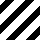
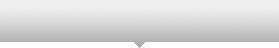
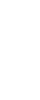
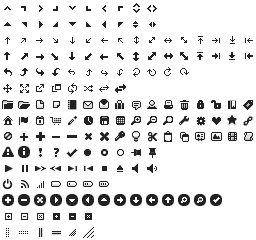
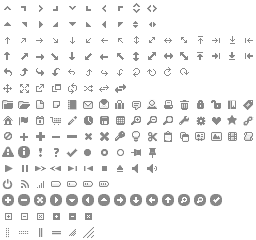
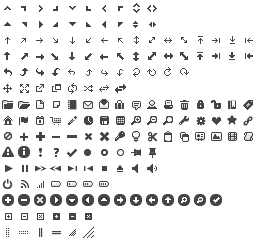
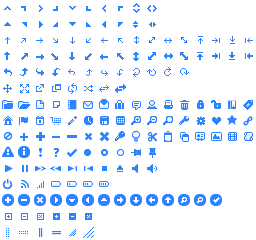
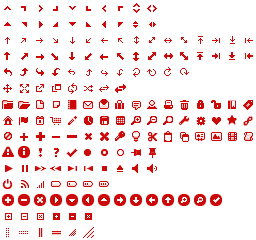
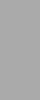
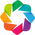
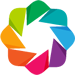
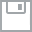
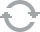
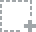
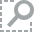
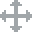
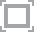
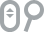

In [582]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

output_notebook()

In [593]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, resize, reset'),
                   #active_scroll=u'wheel_zoom'
                  )

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
#tsne_plot.title.text_font_size = '16pt'
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);